In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import re
%matplotlib inline

In [2]:
# Read in and preprocess the data. Note that this deviates in all kinds
# of ways from the procedure used in Alogna et al. (2014). We don't
# mind, because the point here is to illustrate the effects of model
# misspecification, not to draw any substantive conclusions.
files = glob('../data/*.xls*')
dfs = []

replace = {
    'age18-25 (y/n)': 'age range',
    'gender (m/f)': 'gender',
    'subject number': 'subject',
    'subject#': 'subject',
    'subject_number': 'subject',
    'lineup choice': 'choice',
    'lineup_choice': 'choice',
    'line-up identification': 'choice',
    'response': 'choice',
    'excluded?': 'excluded',
    'verbalization/control': 'condition'
}
for f in files:
    site, study = f.split('.')[0].split('_')
    df = pd.read_excel(f)
    df.columns = [c.lower() for c in df.columns]
    df = df.rename(columns=replace)
    df['site'] = site
    df['study'] = study
    df['id'] = df['site'] + '_' + df['study'] + '_' + df.index.astype(str)
    # Fixes for individual datasets
    if 'brandimonte' in site and study == '1':
        df[df['excluded']==0] = 1
        df['excluded'] = df['excluded'].fillna(0)
    elif 'mccoy' in site:
        df['condition'] -= 1
    dfs.append(df)
    
data = pd.concat(dfs, axis=0)

# Create new cols
data['accuracy'] = (data['choice'] == 6.).astype(int)

# Standardize values
data['excluded'] = data['excluded'].replace({'No': 0, 'N': 0, 'Yes': 1, 'Y': 1, 'YES': 1})
data['excluded'] = data['excluded'].fillna(0)
data['gender'] = data['gender'].replace({'Female': 'F', 'Male': 'M', 'female': 'F', 'male': 'M',
                                         2: 'F', 1: 'M', 'f': 'F', 'm': 'M'})
data['condition'] = data['condition'].replace({'Experimental': 'E', 'Control': 'C', 'exp': 'E',
                                               'c': 'C', 0: 'C', 1: 'E', 'Verbalization': 'E',
                                               'Control': 'C', 'control': 'C', 'experimental': 'E',
                                               'Description': 'E'})
data['dummy'] = 0.
data['str_cond'] = data['condition'].astype('str') + '_' + data['study'].astype('str')

# Drop exclusions
data = data.query('excluded == 0')
data = data.dropna(subset=['condition'])
good_data = data[['id', 'age', 'gender', 'condition', 'site', 'study', 'choice',
                  'confidence', 'dummy', 'accuracy', 'str_cond']]

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [157]:
# Now drill down further to only RRR2
df = good_data.query('study == "2"')

# Replace categorical variables with sequentially numbered ints
df['condition'] = df['condition'].replace(df['condition'].unique(), [0, 1])
sites = df['site'].unique()
df['site'] = df['site'].replace(sites, np.arange(len(sites)))
df.head()

['E' 'C']


/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,id,age,gender,condition,site,study,choice,confidence,dummy,accuracy,str_cond
0,/Users/tal/Dropbox/Projects/overshadowing/bran...,19,F,0,0,2,2.0,2.0,0.0,0,E_2
1,/Users/tal/Dropbox/Projects/overshadowing/bran...,18,F,1,0,2,0.0,5.0,0.0,0,C_2
2,/Users/tal/Dropbox/Projects/overshadowing/bran...,19,F,0,0,2,0.0,1.0,0.0,0,E_2
3,/Users/tal/Dropbox/Projects/overshadowing/bran...,18,F,1,0,2,3.0,3.0,0.0,0,C_2
4,/Users/tal/Dropbox/Projects/overshadowing/bran...,18,F,0,0,2,6.0,4.0,0.0,1,E_2


In [95]:
n_sites = len(sites)

def estimate_model(design_sd=0, **kwargs):
    """ Estimate model in PyMC """
    with pm.Model() as model:
        b_intercept = pm.Normal('intercept', mu=0, sd=1)
        b_condition = pm.Normal('condition', mu=0, sd=1)
        u_intercept_sigma = pm.HalfNormal('site_intercept_sigma', 2)
        u_intercept = pm.Normal('site_intercept', mu=0, sd=u_intercept_sigma, shape=n_sites)
        u_condition_sigma = pm.HalfNormal('site_condition_sigma', 2)
        u_condition = pm.Normal('site_condition', mu=0, sd=u_condition_sigma, shape=n_sites)
        mu = (b_intercept + b_condition * df['condition'] + u_intercept[df['site']] + 
              u_condition[df['site']] * df['condition'])
        if design_sd:
            b_design = pm.Normal('design', mu=0, sd=design_sd)
            mu += b_design * df['condition']

        sigma = pm.HalfNormal('sigma', 2)
        y_hat = pm.Normal('y_hat', mu, sigma, observed=df['accuracy'])

        # For logistic regression, replace above 2 lines with next 2 lines--
        # technically better, but less interpretable, and inconsistent with
        # the Alogna et al. approach.

        # theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
        # y_hat = pm.Bernoulli('y_hat', theta, observed=df['accuracy'])

        trace = pm.sample(**kwargs)
    return trace

In [153]:
# Define the values of \sigma_{unmeasured} we want to estimate with
design_sds = [0, 0.05, 0.075, 0.2, 0.5]

# Estimate models and collect traces
traces_lpm = [estimate_model(design_sd=dsd, draws=2000) for dsd in design_sds]

/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, site_condition, site_condition_sigma, site_intercept, site_intercept_sigma, condition, intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:40<00:00, 248.82draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUT

Design = 0
                          mean        sd  mc_error   hpd_2.5  hpd_97.5  \
intercept             0.416058  0.034577  0.000821  0.348137  0.483930   
condition             0.085704  0.028604  0.000345  0.031152  0.141517   
site_intercept_sigma  0.132880  0.028772  0.000395  0.084479  0.192930   
site_condition_sigma  0.074219  0.033109  0.001093  0.010623  0.130709   
sigma                 0.482626  0.007527  0.000080  0.467959  0.497039   

                            n_eff      Rhat  
intercept             1982.777619  1.000724  
condition             6286.023547  1.000308  
site_intercept_sigma  5360.701736  1.000003  
site_condition_sigma   846.953110  1.000202  
sigma                 8315.788305  1.000164  
Design = 0.05
                          mean        sd  mc_error   hpd_2.5  hpd_97.5  \
intercept             0.415413  0.034315  0.000784  0.350099  0.483786   
condition             0.085130  0.058567  0.001062 -0.032103  0.199765   
site_intercept_sigma  0.132358  

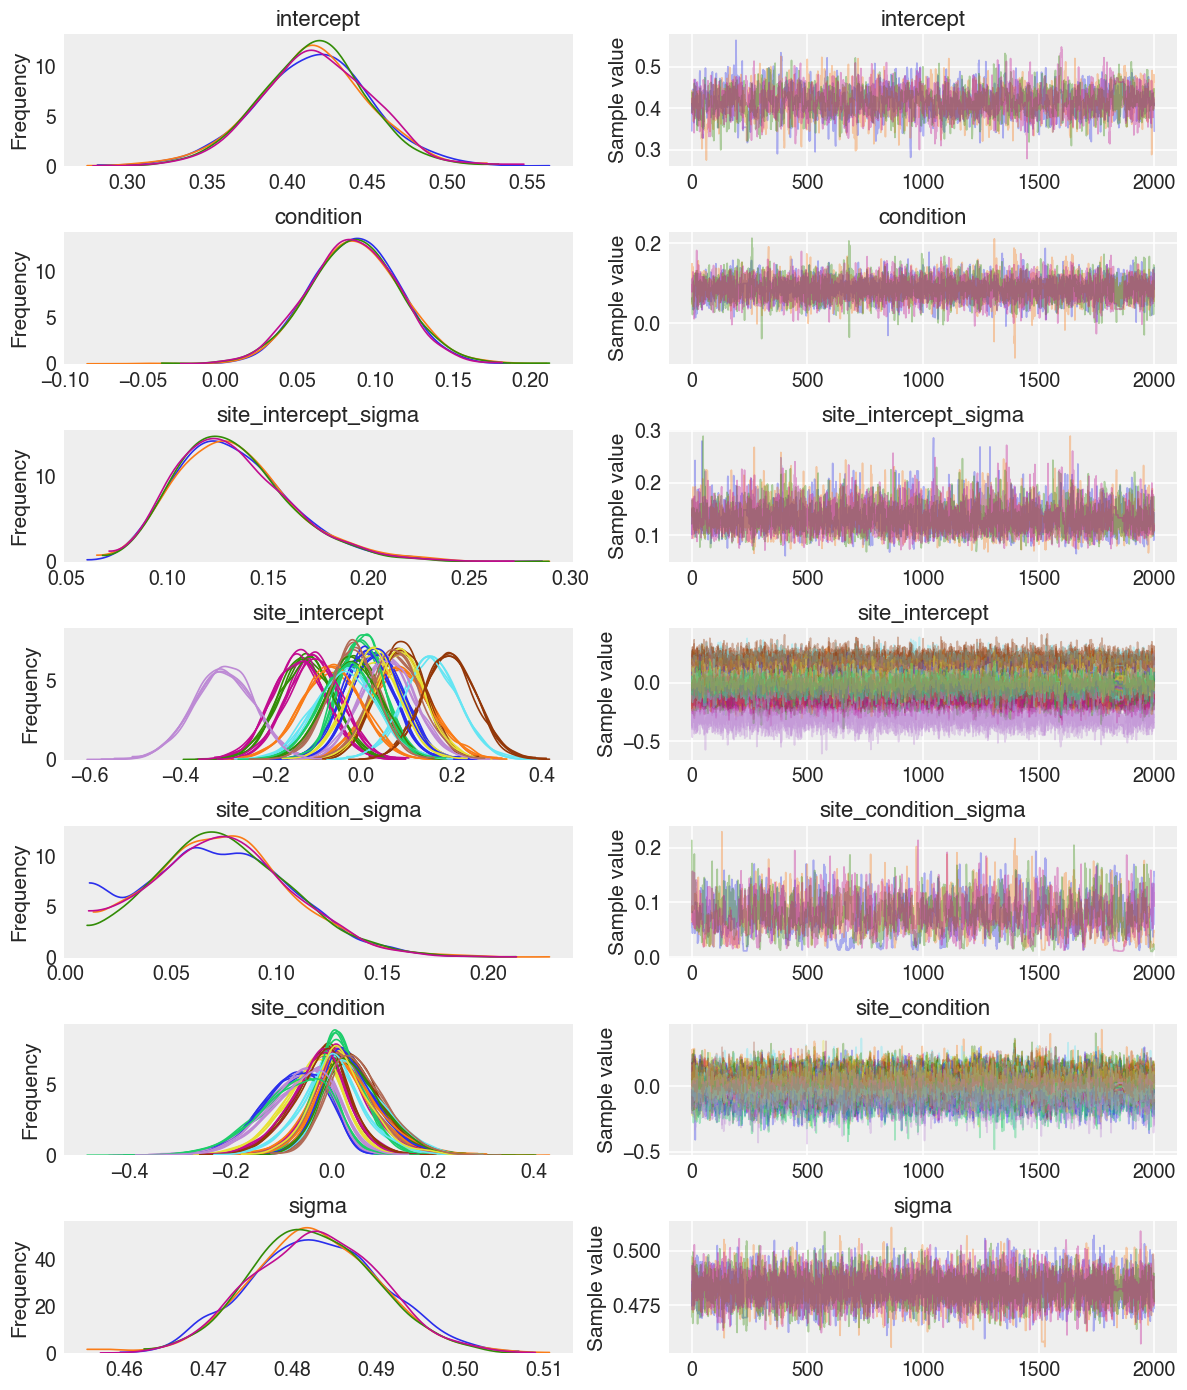

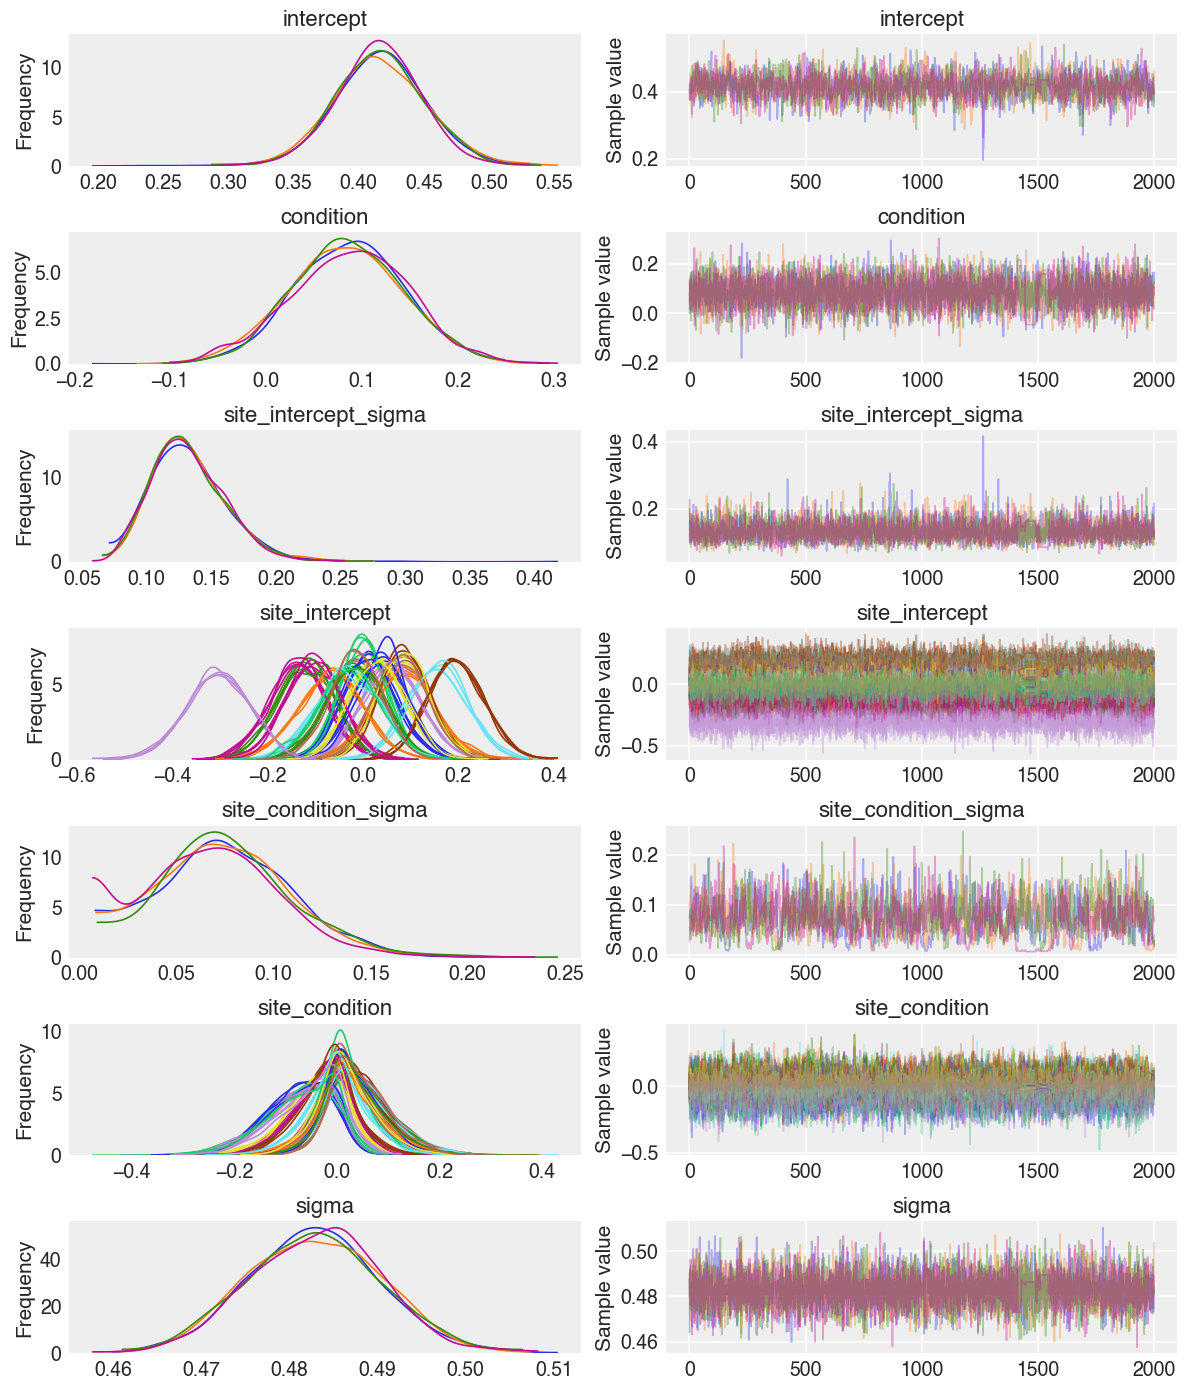

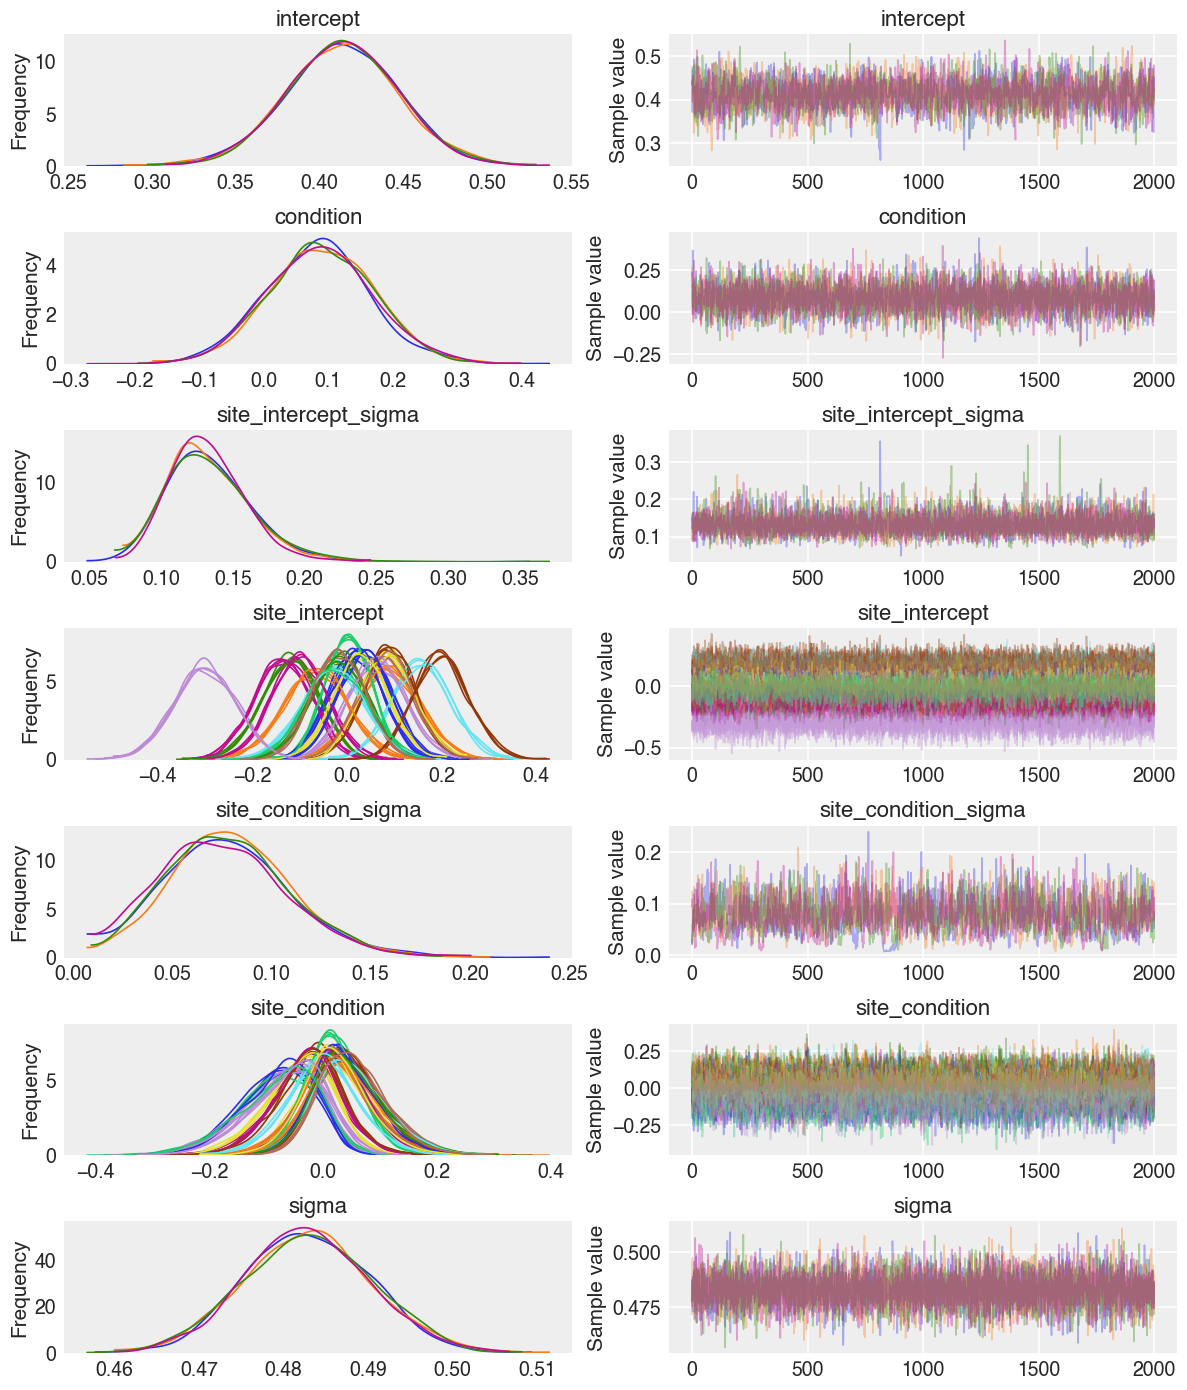

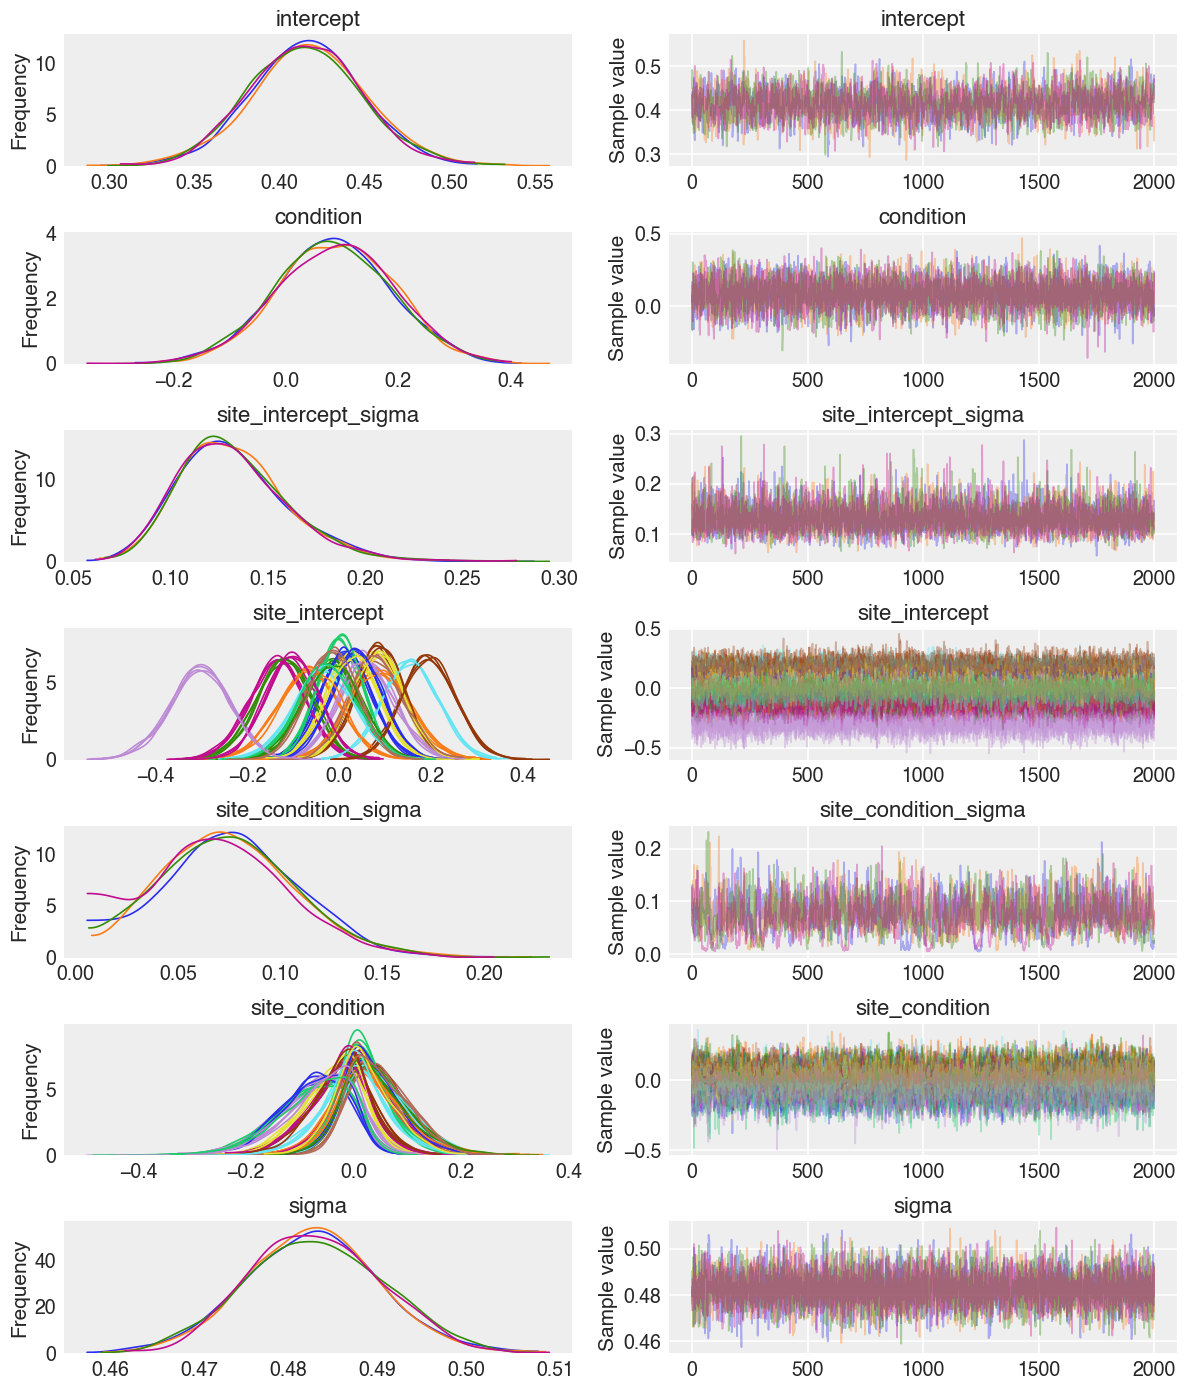

In [97]:
# Plot and summarize the traces, just out of curiosity
plotnames=['intercept', 'condition', 'site_intercept_sigma', 'site_intercept',
                          'site_condition_sigma', 'site_condition', 'sigma']
summnames = ['intercept', 'condition', 'site_intercept_sigma', 'site_condition_sigma', 'sigma']
for i, t in enumerate(traces_lpm):
    print(f"Design = {design_sds[i]}")
    pm.traceplot(t, varnames=plotnames);
    print(pm.summary(t, varnames=summnames))

In [154]:
def get_estimates(traces):
    """ Collect the mean and 95% HPD estimates into a pandas DF """
    bounds = []
    for i, t in enumerate(traces):
        summary = pm.summary(t)
        lb = summary.loc['condition', 'hpd_2.5']
        ub = summary.loc['condition', 'hpd_97.5']
        est = summary.loc['condition', 'mean']
        bounds.append((est, lb, ub))
    index=[f'$\sigma_{{unmeasured}}$ = {d}' for d in design_sds]
    return pd.DataFrame(bounds, columns=['mean', 'hpd_2.5', 'hpd_97.5'],
                        index=index)


def plot_estimates(df, ax=None, title=''):
    """ Make forest plot of estimates """
    if ax is None:
        ax = plt.figure().gca()
    df = df.sort_index(ascending=False)
    y = np.arange(len(df)) + 0.5
    xerr = (df.loc[:, ['hpd_2.5', 'hpd_97.5']].apply(lambda x: x - df['mean'])).values
    xerr[:, 0] = np.abs(xerr[:, 0])
    ax.errorbar(df['mean'], y, xerr=xerr.T, fmt='o', color='k', capsize=4, capthick=1)
    ax.set_ylim(0, len(df))
    ax.grid(axis='x', linestyle='--')
    ax.grid(False, axis='y')
    ax.set_yticks(y, False)
    labels = df.index
    ax.set_yticklabels(labels)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_ylabel("Assumed variance", fontsize=12)
    ax.set_xlabel("Experimental effect (change in accuracy)", fontsize=12)

In [155]:
# Collect the estimates
estimates_lpm = get_estimates(traces_lpm)
estimates_lpm

,mean,hpd_2.5,hpd_97.5
$\sigma_{unmeasured}$ = 0,0.086136,0.030277,0.141190
$\sigma_{unmeasured}$ = 0.05,0.085689,-0.027195,0.192980
$\sigma_{unmeasured}$ = 0.075,0.084969,-0.075651,0.238436
$\sigma_{unmeasured}$ = 0.2,0.082726,-0.293643,0.475711
$\sigma_{unmeasured}$ = 0.5,0.071153,-0.797194,0.911373


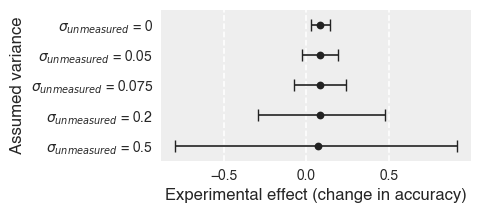

In [156]:
# Plot!
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
plot_estimates(estimates_lpm, ax=ax, title="", left_ax=True)
plt.tight_layout
# Uncomment next line to save
# plt.savefig('../figures/Figure2', dpi=200, bbox_inches='tight')